### Write link files for chord diagrams. This is for the circos package.

Download circos here: http://circos.ca/software/download/

There are pre-written files in the ./circos directory: 
- circos_athamontanolide.conf
- circos_noscapine.conf
- ticks.conf
- kary_single_plainbands.txt

These are configuration files used by the circos package, used to adjust the appearance of the chord diagram.



In [1]:
from rdkit import Chem
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from tqdm.notebook import tqdm
import os 

In [2]:
col_map = plt.cm.get_cmap('plasma')

def rgb_convert(rgb,alpha):
    """ rgb is a tuple of rgb in 0-1
    alpha is the alpha."""

    rgb = [round(255*x,5) for x in rgb[:3]]

    return f"({rgb[0]},{rgb[1]},{rgb[2]},{alpha})"

### load data

In [3]:
# swap out the data later...
data = pd.read_csv("./data_files/smiles_min_dist_dbank_props.csv")
data.sort_values("min_dist_all",inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,smiles,min_dist_all,natoms,drugbank_matches,LogP,MW,HBD,HBA,PSA,ROTB,FSP3,SSSR,QED
0,CCC(=O)O,0.0,5,2357,0.4810,74.079,1.0,1.0,37.30,1.0,0.666667,0.0,0.490845
1,C=CC(=O)O,0.0,5,321,0.2570,72.063,1.0,1.0,37.30,1.0,0.000000,0.0,0.450858
2,CC(N)C(C)C(=O)O,1.0,8,36,0.0543,117.148,2.0,2.0,63.32,2.0,0.800000,0.0,0.536977
3,C=CNC(=C)C(=O)O,1.0,8,1,0.3178,113.116,2.0,2.0,49.33,3.0,0.000000,0.0,0.517939
4,O=C1CCO1,1.0,5,3,-0.0667,72.063,0.0,2.0,26.30,0.0,0.666667,1.0,0.374381


In [4]:
data = data[(data.SSSR<=4) & (data.min_dist_all<=6)].copy()
data.reset_index(drop=True,inplace=True)

### load drug and search

In [5]:
noscapine = "O=C2O[C@@H](c1ccc(OC)c(OC)c12)[C@@H]5N(C)CCc4c5c(OC)c3OCOc3c4"

In [6]:
search_molecule = Chem.MolFromSmiles(noscapine)
match_data = []

for s in tqdm(data.smiles):
    m = Chem.MolFromSmiles(s)
    match_data.append(len(search_molecule.GetSubstructMatches(m)))

  0%|          | 0/80941 [00:00<?, ?it/s]

In [7]:
data["nmatches"] = match_data
data.sort_values("nmatches",ascending=True,inplace=True)

### process and write linker file

In [8]:
# color and location settings
# location on the black band - arbitrary
ndrug=10

chr_name1 = "drug"
chr_name2 = "aciami"

# color_log: whether to color by log of matches, or not
# interp10: whether to cap the matches at 10.
# alpha: the line transparency
color_log = False
interp10 = True
alpha = 0.5


nhits = data['nmatches'].values

if color_log: nhits = np.log10(nhits)

if interp10:
    inter = np.interp(nhits,(1,10),(-0,+1))
else:
    n_max = nhits.max()
    n_min = nhits.min()
    inter = np.interp(nhits,(n_min,n_max),(-0,+1))

line_colors = [rgb_convert(col_map(i),alpha) for i in inter]

f_out = open("./circos/circos_links_noscapine.txt","w")

for i, line in enumerate(data.itertuples()):
    if line.nmatches>0:
        link_line = f"{chr_name1} {ndrug} {ndrug+1} {chr_name2} {line.Index} {line.Index+1} color={line_colors[i]}\n"
        f_out.write(link_line)
    
f_out.close()
    


### draw matched structures

In [9]:
data.sort_values(["min_dist_all","nmatches"],ascending=[True,False],inplace=True)

In [10]:
matched_smiles = list(data[data.nmatches!=0].smiles)
matched_mols = [Chem.MolFromSmiles(s) for s in matched_smiles]

In [11]:
img = Chem.Draw.MolsToGridImage(matched_mols,maxMols=100,molsPerRow=10,returnPNG=False,subImgSize=(200,100))
img.save('./circos/nosc_match_strcutures.png')    

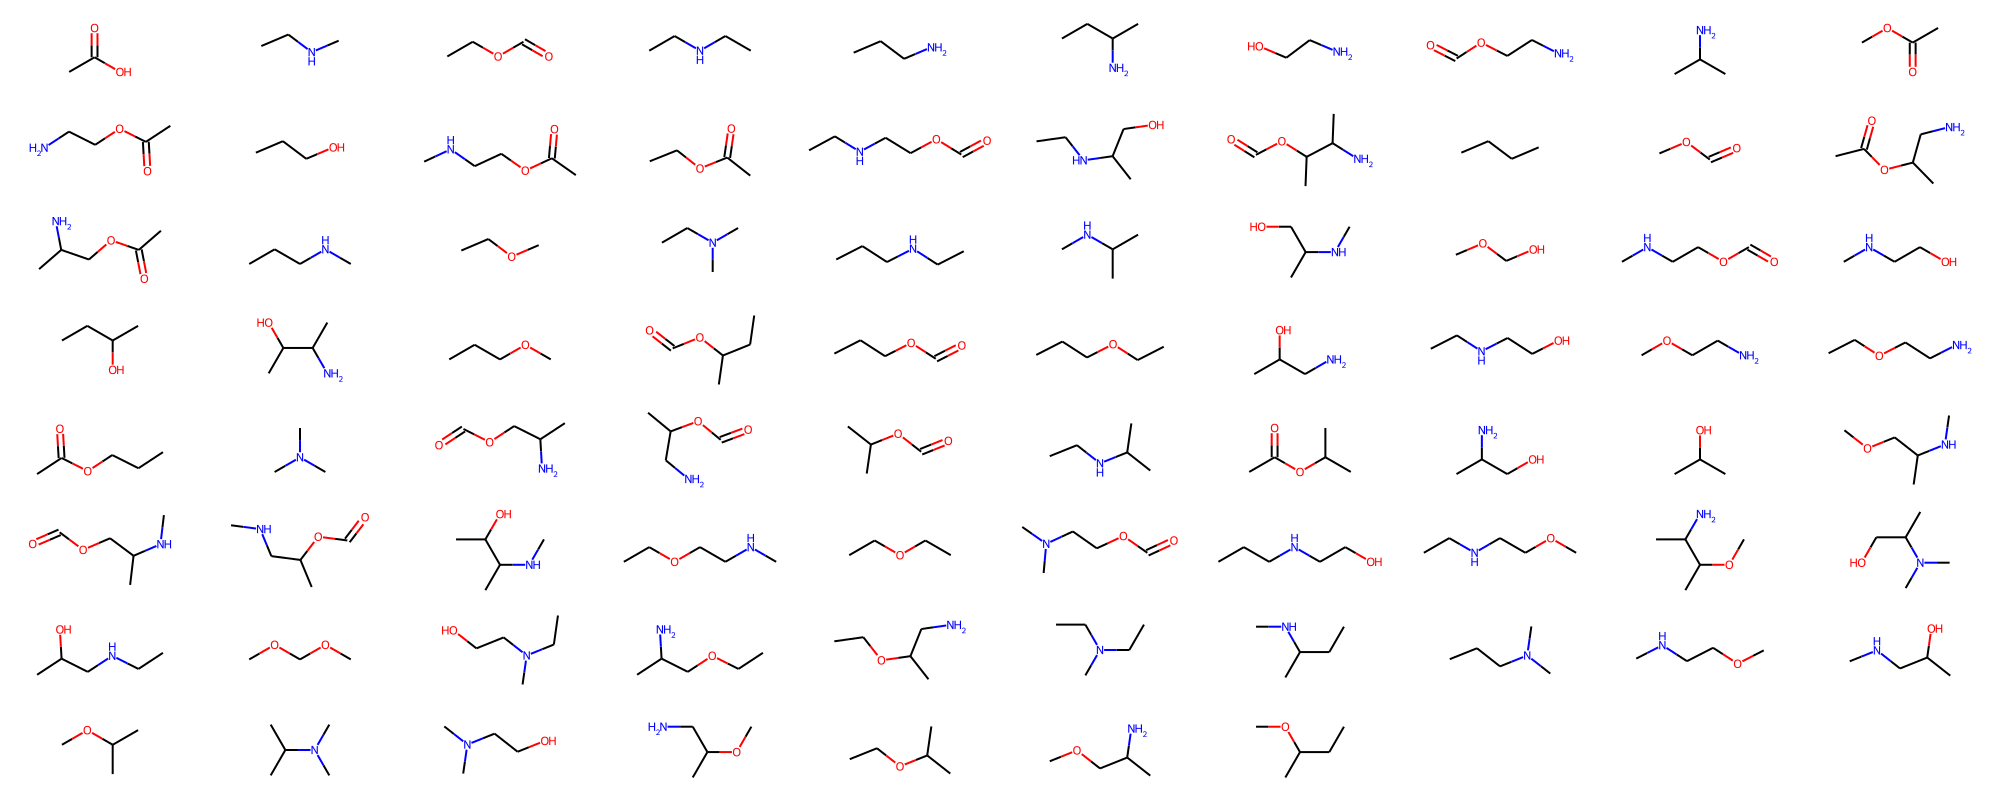

In [12]:
img

### do the same for athamontanolide

In [13]:
athamontanolide = "O=C1C(C2[C@@H](OC(C)=O)CC(C)=C3C=C[C@](C)(O)C3C2O1)=C"

search_molecule = Chem.MolFromSmiles(athamontanolide)
match_data = []

for s in tqdm(data.smiles):
    m = Chem.MolFromSmiles(s)
    match_data.append(len(search_molecule.GetSubstructMatches(m)))
    
data["nmatches"] = match_data
data.sort_values("nmatches",ascending=True,inplace=True)

  0%|          | 0/80941 [00:00<?, ?it/s]

In [14]:
# color and location settings
ndrug=5

chr_name1 = "drug"
chr_name2 = "aciami"

# color_log: whether to color by log of matches, or not
# interp10: whether to cap the matches at 10.
# alpha: the line transparency
color_log = False
interp10 = True
alpha = 0.5


nhits = data['nmatches'].values

if color_log: nhits = np.log10(nhits)

if interp10:
    inter = np.interp(nhits,(1,10),(-0,+1))
else:
    n_max = nhits.max()
    n_min = nhits.min()
    inter = np.interp(nhits,(n_min,n_max),(-0,+1))

line_colors = [rgb_convert(col_map(i),alpha) for i in inter]

f_out = open("./circos/circos_links_athamontanolide.txt","w")

for i, line in enumerate(data.itertuples()):
    if line.nmatches>0:
        link_line = f"{chr_name1} {ndrug} {ndrug+1} {chr_name2} {line.Index} {line.Index+1} color={line_colors[i]}\n"
        f_out.write(link_line)
    
f_out.close()
    


In [15]:
data.sort_values(["min_dist_all","nmatches"],ascending=[True,False],inplace=True)
matched_smiles = list(data[data.nmatches!=0].smiles)

In [16]:
len(matched_smiles)

121

In [17]:
matched_smiles = list(data[data.nmatches!=0].smiles)
matched_mols = [Chem.MolFromSmiles(s) for s in matched_smiles]
img = Chem.Draw.MolsToGridImage(matched_mols,maxMols=130,molsPerRow=10,returnPNG=False,subImgSize=(200,100))
img.save('./circos/atha_match_strcutures.png')    

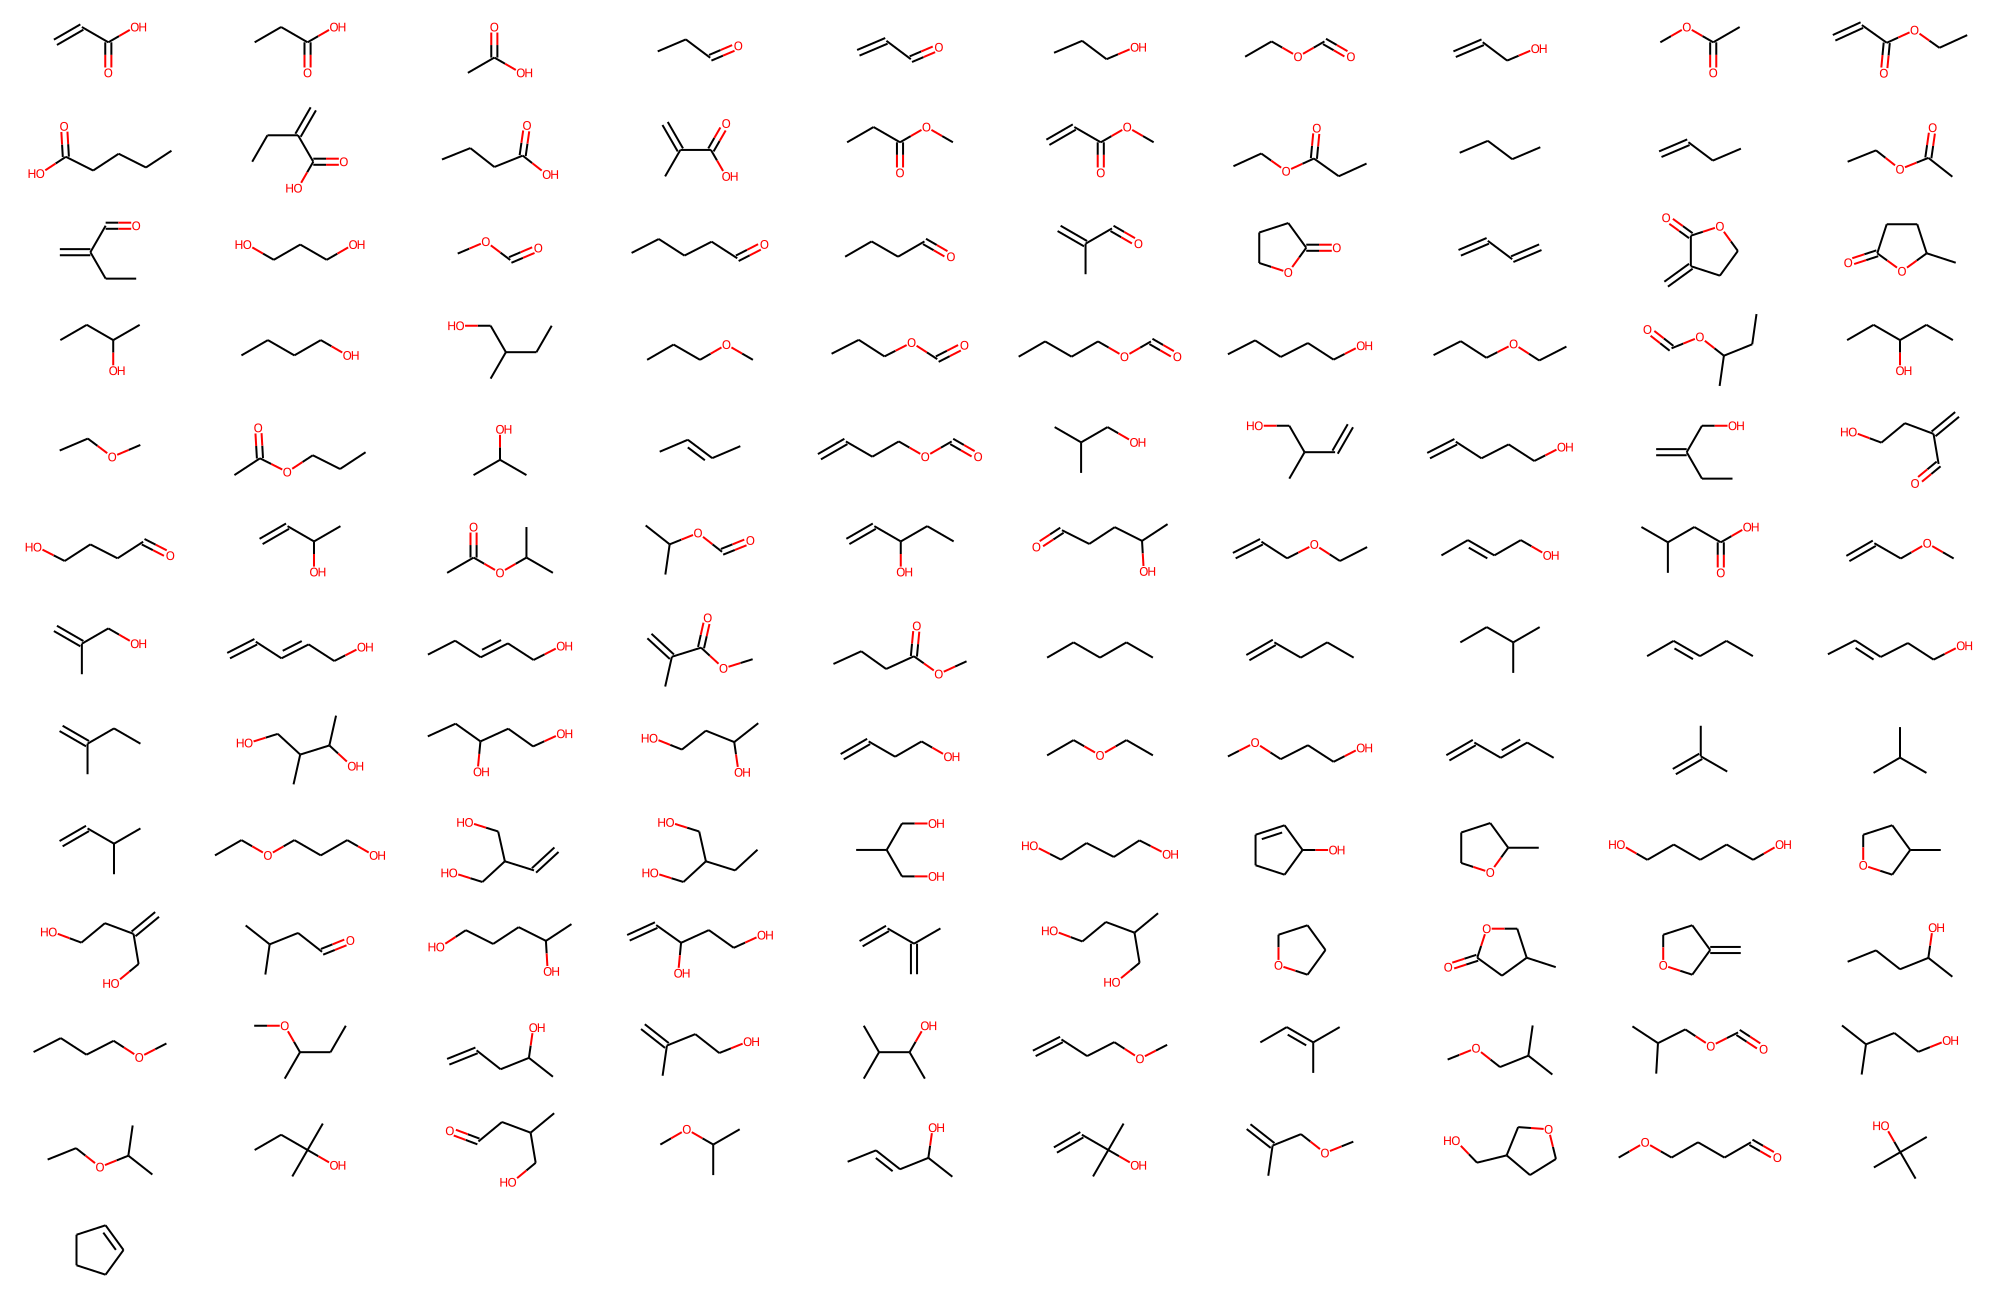

In [18]:
img

### draw chord diagrams

In [21]:
# draw for athamontanolide
# replace the path below with your local circos install.

!..\..\circos-0.69-9\bin\circos -conf ./circos/circos_athamontanolide.conf

# move output into the circos folder
os.rename("./circos.png","./circos/circos_athamontanolide.png")

debuggroup summary 0.15s welcome to circos v0.69-8 15 Jun 2019 on Perl 5.014002
debuggroup summary 0.15s current working directory C:/Users/Cernak/Desktop/qcr_temp/zzz_paper_submit_2
debuggroup summary 0.15s command C:\Users\Cernak\Desktop\circos-0.69-9\bin\circos.exe -conf ./circos/circos_athamontanolide.conf
debuggroup summary 0.15s loading configuration from file ./circos/circos_athamontanolide.conf
debuggroup summary 0.15s found conf file ./circos/circos_athamontanolide.conf
debuggroup summary 0.29s debug will appear for these features: output,summary
debuggroup summary 0.29s bitmap output image ./.\circos.png
debuggroup summary 0.29s parsing karyotype and organizing ideograms
debuggroup summary 0.30s karyotype has 2 chromosomes of total size 81,017
debuggroup summary 0.30s applying global and local scaling
debuggroup summary 0.30s allocating image, colors and brushes
debuggroup summary 1.86s drawing 2 ideograms of total size 81,017
debuggroup summary 1.86s drawing highlights and i

In [22]:
# draw for noscapine
# replace the path below with your local circos install.

!..\..\circos-0.69-9\bin\circos -conf ./circos/circos_noscapine.conf
os.rename("./circos.png","./circos/circos_noscapine.png")

debuggroup summary 0.14s welcome to circos v0.69-8 15 Jun 2019 on Perl 5.014002
debuggroup summary 0.14s current working directory C:/Users/Cernak/Desktop/qcr_temp/zzz_paper_submit_2
debuggroup summary 0.14s command C:\Users\Cernak\Desktop\circos-0.69-9\bin\circos.exe -conf ./circos/circos_noscapine.conf
debuggroup summary 0.14s loading configuration from file ./circos/circos_noscapine.conf
debuggroup summary 0.15s found conf file ./circos/circos_noscapine.conf
debuggroup summary 0.28s debug will appear for these features: output,summary
debuggroup summary 0.29s bitmap output image ./.\circos.png
debuggroup summary 0.29s parsing karyotype and organizing ideograms
debuggroup summary 0.29s karyotype has 2 chromosomes of total size 81,017
debuggroup summary 0.30s applying global and local scaling
debuggroup summary 0.30s allocating image, colors and brushes
debuggroup summary 1.87s drawing 2 ideograms of total size 81,017
debuggroup summary 1.87s drawing highlights and ideograms
debuggrou